# Extracting electrical features and plotting traces using BluePyEfe

This notebook will show you how to use BluePyEfe to extract electrical features from experimental voltage traces. For this example we will use the rat somatosensory cortex data available at: http://microcircuits.epfl.ch/#/article/article_4_eph

Author of this script: Tanguy Damart @ Blue Brain Project

In [1]:
import pathlib
from pprint import pprint
import matplotlib.pyplot as plt

import bluepyefe
import bluepyefe.extract

## Using BluePyEfe to extract data and plot traces for a single cell

The low level class in BluePyEfe is called "Cell". It is instanciated as follow:

In [3]:
from bluepyefe.cell import Cell

cell = Cell(name="MouseNeuron")

The recording_reader argument is used to pass a reader function that should match the format of the files. Here we will trust the automatic detection of the format that uses the extension of the file.

Right now, the cell is empty. But it will become a recipient for the recording's data. For that let's use one of the data file present in the tests/exp_data directory. To read a data file, our cell also needs the metadata associated in the form of a dictionnary:

In [4]:
files_metadata = {
    "i_file": "../tests/exp_data/B95_Ch0_IDRest_107.ibw",
    "v_file": "../tests/exp_data/B95_Ch3_IDRest_107.ibw",
    "i_unit": "pA",
    "v_unit": "mV",
    "t_unit": "s",
    "dt": 0.00025,
    "ljp": 14.
}

The exact fields of this dictionary depend of the metadata already present in your file. Check the reader functions present in bluepyefe/reader.py to see which entries are needed.

The units should be the ones in which the recording file is, not the units you want the output to be in. The output units will always be ms, nA, mV.

Using this metadata the cell is able to read the data file. The data is now accessible through the "recordings" attribute. "recordings" is a list that contains as many element as recordings present in the data file:

In [6]:
cell.read_recordings(
    protocol_data=[files_metadata], 
    protocol_name="IDRest"
)

pprint(vars(cell.recordings[0]))

{'amp': 0.037498171441257,
 'amp_rel': None,
 'config_data': {'dt': 0.00025,
                 'i_file': '../tests/exp_data/B95_Ch0_IDRest_107.ibw',
                 'i_unit': 'pA',
                 'ljp': 14.0,
                 't_unit': 's',
                 'v_file': '../tests/exp_data/B95_Ch3_IDRest_107.ibw',
                 'v_unit': 'mV'},
 'current': array([-0.02812363, -0.03437332, -0.03124848, ..., -0.03749817,
       -0.02812363, -0.02812363], dtype=float32),
 'dt': 0.25,
 'efeatures': {},
 'files': ['../tests/exp_data/B95_Ch0_IDRest_107.ibw',
           '../tests/exp_data/B95_Ch3_IDRest_107.ibw'],
 'hypamp': -0.03124847635626793,
 'hypamp_rel': None,
 'id': None,
 'location': None,
 'protocol_name': 'IDRest',
 'reader_data': {'current': array([-28.123627, -34.37332 , -31.248474, ..., -37.49817 , -28.123627,
       -28.123627], dtype=float32),
                 'dt': 0.00025,
                 'i_unit': 'pA',
                 'v_unit': 'mV',
                 'voltage': array([-

Let's select the first trace and plot it using matplotlib:

Text(0, 0.5, 'Voltage (mV)')

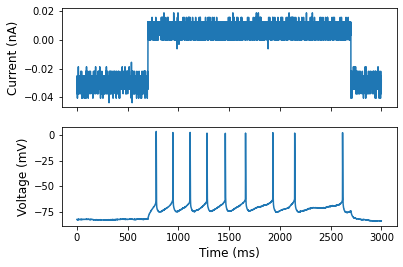

In [7]:
recording = cell.recordings[0]

fig, axs = plt.subplots(2, sharex=True)

axs[0].plot(recording.t, recording.current, label='current')
axs[0].set_ylabel("Current (nA)", size="large")

axs[1].plot(recording.t, recording.voltage, label='current')
axs[1].set_xlabel("Time (ms)", size="large")
axs[1].set_ylabel("Voltage (mV)", size="large")

Since we did not specify a starting time, finishing time, step amplitude and holding current in the metadata, we can ask BluePyEfe to infer them from the current time series. To do so we need to tell the Recording what kind of current shape (eCode) it has to expect. If you are unhappy with the results, you can set the eCode parameters through the metadata (for a step current, the parameters are 'ton', 'toff', 'tend', 'dt', 'amp', and 'hypamp').

In [8]:
pprint(recording.get_params())

{'amp': 0.037498171441257,
 'amp_rel': None,
 'dt': 0.25,
 'hypamp': -0.03124847635626793,
 'hypamp_rel': None,
 'tend': 3000.0,
 'toff': 2700.0,
 'ton': 700.25}


To check if the eCode was interpreted correctly, we can compare the original current array (in blue) with an artificial one generated from the ecode_params (in orange):

Text(0.5, 0, 'Time (ms)')

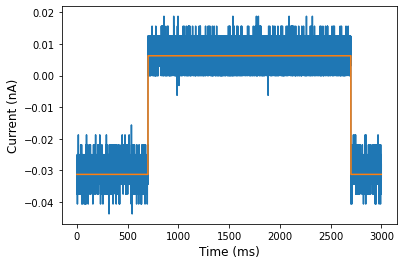

In [9]:
generated_current = recording.generate()

fig, ax = plt.subplots()
ax.plot(recording.t, recording.current, label='current', c='C0')
ax.plot(generated_current[0], generated_current[1], label='current', c='C1')
ax.set_ylabel("Current (nA)", size="large")
ax.set_xlabel("Time (ms)", size="large")

Now that we have a voltage time series, we can get efeatures from it. A list of all the features available can be found in the documentation of the eFEL package (https://efel.readthedocs.io/en/latest/eFeatures.html). For now, let's make a list with a few features and extract them from all the recordings labelled as "IDRest" protocols:

In [11]:
interesting_efeatures = [
    'Spikecount',
    'mean_frequency',
    'ISI_CV',
    'AP1_amp',
    'AP_width'
]

for efeature in interesting_efeatures:
    cell.extract_efeatures(
        protocol_name='IDRest', 
        efeatures=interesting_efeatures
    )

pprint(cell.recordings[0].efeatures)

{'AP1_amp': 66.6842460613687,
 'AP_width': 1.5333333333374715,
 'ISI_CV': 0.45426236044311097,
 'Spikecount': 9.0,
 'mean_frequency': 4.692387904054155}


## Using BluePyEfe as a bulk efeatures extraction tool

We saw how to read recordings and extract features for a single cell, however the true use of BluePyEfe is to do so for groups of cells.

The first thing we will need to do so is to create a dictionary containing the metadata for all the files we want to use. For the current example on two cells, the structure of this dictionary will be as follows:

In [14]:
import glob

# Get the path of the files for the first cell and build the metadata dictionaries
files_metadata1 = []
for file in glob.glob("../tests/exp_data/B6/B6_Ch0_IDRest_*.ibw"):
    files_metadata1.append({"i_file": file,
                            "v_file": file.replace("Ch0", "Ch3"),
                            "i_unit": "pA",
                            "v_unit": "mV",
                            "t_unit": "s",
                            "dt": 0.00025,
                            "ljp": 14.}
                          )

# Do the same for the second cell
files_metadata2 = []
for file in glob.glob("../tests/exp_data/B8/B8_Ch0_IDRest_*.ibw"):
    files_metadata2.append({"i_file": file,
                            "v_file": file.replace("Ch0", "Ch3"),
                            "i_unit": "pA",
                            "v_unit": "mV",
                            "t_unit": "s",
                            "dt": 0.00025,
                            "ljp": 14.}
                          )

files_metadata = {
    'MouseNeuron1': {'IDRest': files_metadata1},
    'MouseNeuron2': {'IDRest': files_metadata2}
}

In [15]:
files_metadata

{'MouseNeuron1': {'IDRest': [{'i_file': '../tests/exp_data/B6/B6_Ch0_IDRest_182.ibw',
    'v_file': '../tests/exp_data/B6/B6_Ch3_IDRest_182.ibw',
    'i_unit': 'pA',
    'v_unit': 'mV',
    't_unit': 's',
    'dt': 0.00025,
    'ljp': 14.0},
   {'i_file': '../tests/exp_data/B6/B6_Ch0_IDRest_183.ibw',
    'v_file': '../tests/exp_data/B6/B6_Ch3_IDRest_183.ibw',
    'i_unit': 'pA',
    'v_unit': 'mV',
    't_unit': 's',
    'dt': 0.00025,
    'ljp': 14.0},
   {'i_file': '../tests/exp_data/B6/B6_Ch0_IDRest_184.ibw',
    'v_file': '../tests/exp_data/B6/B6_Ch3_IDRest_184.ibw',
    'i_unit': 'pA',
    'v_unit': 'mV',
    't_unit': 's',
    'dt': 0.00025,
    'ljp': 14.0},
   {'i_file': '../tests/exp_data/B6/B6_Ch0_IDRest_181.ibw',
    'v_file': '../tests/exp_data/B6/B6_Ch3_IDRest_181.ibw',
    'i_unit': 'pA',
    'v_unit': 'mV',
    't_unit': 's',
    'dt': 0.00025,
    'ljp': 14.0},
   {'i_file': '../tests/exp_data/B6/B6_Ch0_IDRest_185.ibw',
    'v_file': '../tests/exp_data/B6/B6_Ch3_IDRest_

We can now read these recordings. The result of this step is a list of Cells that contains the recordings:

In [16]:
cells = bluepyefe.extract.read_recordings(files_metadata=files_metadata)

pprint(vars(cells[0].recordings[0]))

{'amp': 0.17499145679175854,
 'amp_rel': None,
 'config_data': {'dt': 0.00025,
                 'i_file': '../tests/exp_data/B6/B6_Ch0_IDRest_182.ibw',
                 'i_unit': 'pA',
                 'ljp': 14.0,
                 't_unit': 's',
                 'v_file': '../tests/exp_data/B6/B6_Ch3_IDRest_182.ibw',
                 'v_unit': 'mV'},
 'current': array([-0.01562424, -0.01562424, -0.01562424, ..., -0.01249939,
       -0.01562424, -0.00937454], dtype=float32),
 'dt': 0.25,
 'efeatures': {},
 'files': ['../tests/exp_data/B6/B6_Ch0_IDRest_182.ibw',
           '../tests/exp_data/B6/B6_Ch3_IDRest_182.ibw'],
 'hypamp': -0.012499390169978142,
 'hypamp_rel': None,
 'id': None,
 'location': None,
 'protocol_name': 'IDRest',
 'reader_data': {'current': array([-15.624237, -15.624237, -15.624237, ..., -12.49939 , -15.624237,
        -9.374542], dtype=float32),
                 'dt': 0.00025,
                 'i_unit': 'pA',
                 'v_unit': 'mV',
                 'voltage

The main purpose of BluePyEFe is to output efeatures and protocols that can then be used as input by BluePyOpt. To do so, the efeatures need to be averaged over the cells present in the dataset for different step current amplitude referred to as "targets". These targets need to be defined as percentages of the spiking threshold of the cells, here 150%, 200% and 250%.

Therefore, the second requirement to be able to extract efeatures is a dictionary containing theses targets. They are defined as a combination of a protocol name, target amplitude and names of the efeatures:

In [16]:
interesting_amplitudes = [150, 200, 250]

targets = []
for efeature in interesting_efeatures:
    for amplitude in interesting_amplitudes:

        target = {
            "efeature": efeature,
            "protocol": "IDRest",
            "amplitude": amplitude,
            "tolerance": 20.,
        }

        targets.append(target)

We can now extract the efeatures for these targets:

In [17]:
cells = bluepyefe.extract.extract_efeatures_at_targets(
        cells=cells,
        targets=targets
)

for cell in cells:
    print("\nCell " + cell.name, ": ")
    pprint(cell.recordings[0].efeatures)


Cell MouseNeuron1 : 
{'AP1_amp': 60.77828405642581,
 'AP_width': 1.3280000000038126,
 'ISI_CV': 0.07030517050942046,
 'Spikecount': 50.0,
 'mean_frequency': 25.303643724627815}

Cell MouseNeuron2 : 
{'AP1_amp': 68.93413734639098,
 'AP_width': 1.457000000004097,
 'ISI_CV': 0.08757930621841394,
 'Spikecount': 75.0,
 'mean_frequency': 37.921880925191125}


And we can plot the recordings for all the cells using the "Plotter" class of BluePyEfe. The plots won't appear here but will be saved as pdfs in the 'MouseCells' directory:

In [18]:
from bluepyefe.plotting import plot_all_recordings

output_dir = 'MouseCells'
plot_all_recordings(cells, output_dir)

<Figure size 432x288 with 0 Axes>

The average efeatures for the dataset are a function of the relative amplitude of the step currents with respect to be the rheobase. To be able to compute these relative amplitudes for each cell, we would need for example "IDThresh" data which are often used to find the minimum step current that can induce a spike. In the case where you have data to compute the rheobase (for example IDThresh traces), you will have to pass the list of the protocol names you want to use for this task in protocols_rheobase, e.g:

analyse_threshold(protocols_rheobase  = ["IDThresh", "IV"]).

Since we do not have this data in this example, we are going to set the threshold current by hand for our cells and then ask BluePyEfe to compute the relative amplitude for all the traces:

In [19]:
# analyse_threshold(protocols_threshold = ["IDThresh", "IV"]).

for cell in cells:
    cell.rheobase = 0.07
    cell.compute_relative_amp()

We can now compute the mean efeatures for our dataset and output the efeatures and protocols files which will also be saved in the MouseCells directory:

In [21]:
protocols = bluepyefe.extract.group_efeatures(cells, targets)

efeatures, protocol_definitions, currents = bluepyefe.extract.create_feature_protocol_files(
    cells=cells,
    protocols=protocols,
    output_directory='MouseCells'
)

pprint(efeatures)
pprint(protocol_definitions)
pprint(currents)

Standard deviation for efeatures Spikecount stimulus IDRest is 0 andwill be set to 1e-3
Standard deviation for efeatures mean_frequency stimulus IDRest is 0 andwill be set to 1e-3
Standard deviation for efeatures ISI_CV stimulus IDRest is 0 andwill be set to 1e-3
Standard deviation for efeatures AP1_amp stimulus IDRest is 0 andwill be set to 1e-3
Standard deviation for efeatures AP_width stimulus IDRest is 0 andwill be set to 1e-3


{'IDRest_150': {'soma': [{'feature': 'Spikecount', 'n': 2, 'val': [23.0, 3.0]},
                         {'feature': 'mean_frequency',
                          'n': 2,
                          'val': [11.771430784943579, 1.6410015080304046]},
                         {'feature': 'ISI_CV',
                          'n': 2,
                          'val': [0.23595107183815314, 0.016515005372327057]},
                         {'feature': 'AP1_amp',
                          'n': 2,
                          'val': [64.85620879476767, 5.077877041131593]},
                         {'feature': 'AP_width',
                          'n': 2,
                          'val': [1.3661538461578737, 0.07384615384613147]}]},
 'IDRest_200': {'soma': [{'feature': 'Spikecount',
                          'n': 1,
                          'val': [44.0, 0.001]},
                         {'feature': 'mean_frequency',
                          'n': 1,
                          'val': [22.38900903186924, 0

We can also plot the summary efeature plots for the cells which will also be saved as pdfs in the MouseCells directory. On these plots, to know which marker style corresponds to which cells, use the legend.pdf file.

In [22]:
from bluepyefe.plotting import plot_individual_efeatures, plot_grouped_efeatures

plot_individual_efeatures(cells, protocols, output_dir, key_amp='amp_rel')
plot_grouped_efeatures(cells, protocols, output_dir, key_amp="amp_rel")

<Figure size 432x288 with 0 Axes>

## Using BluePyEfe to extract efeatures and plot them in one line

The following command performs all the operations detailed above. It is convenient when using BluePyEfe in other workflow or when interacting with the Extractor object is not needed:

Note: this command will not produce any useful result in the present case as we do not have data to compute the rheobase of the cells.

In [32]:
bluepyefe.extract.extract_efeatures(
    output_directory='MouseCells',
    files_metadata=files_metadata,
    targets=targets,
    threshold_nvalue_save=1,
    protocols_rheobase=[],
    spike_threshold_rheobase=-20.,
    write_files=True,
    plot=True,
)

Number of values < threshold_nvalue_save for efeatureSpikecount stimulus IDRest_150. The efeature will be ignored
Number of values < threshold_nvalue_save for efeaturemean_frequency stimulus IDRest_150. The efeature will be ignored
Number of values < threshold_nvalue_save for efeatureISI_CV stimulus IDRest_150. The efeature will be ignored
Number of values < threshold_nvalue_save for efeatureAP1_amp stimulus IDRest_150. The efeature will be ignored
Number of values < threshold_nvalue_save for efeatureAP_width stimulus IDRest_150. The efeature will be ignored
No efeatures for stimulus IDRest_150. The protocol will not be created.
Number of values < threshold_nvalue_save for efeatureSpikecount stimulus IDRest_200. The efeature will be ignored
Number of values < threshold_nvalue_save for efeaturemean_frequency stimulus IDRest_200. The efeature will be ignored
Number of values < threshold_nvalue_save for efeatureISI_CV stimulus IDRest_200. The efeature will be ignored
Number of values < th

({},
 {},
 {'holding_current': [-0.032810899429023266, 0.020311509259045124],
  'threshold_current': [nan, nan],
  'all_holding_current': {'MouseNeuron1': -0.012499390169978142,
   'MouseNeuron2': -0.05312240868806839},
  'all_threshold_current': {}})

<Figure size 432x288 with 0 Axes>